<h2>Imports</h2>

In [20]:
import os
import cv2
import matplotlib.pyplot as plt
from ultralytics import YOLO
import seaborn as sns
import math

test_set = "/home/theo/Documents/Unif/Master/Chimprec - Extra/Detection - test set"
model_path = "/home/theo/Documents/Unif/Master/body/"
models = [
    "v8n",
    "v8s",
    "v10n",
    "v10s",
    "v10m"
]
# test_set = "C:/Users/julie/OneDrive - UCL/Master_2/Mémoire/Chimprec Dataset/ChimpRec Detection/Test set"
# model_path = "C:/Users/julie/OneDrive - UCL/Master_2/Mémoire/ChimpRec/Code/Body_detection/YOLO_small/runs/detect/train9/weights/best.pt"

def yolo_to_relative_coord(bbox, img_dim):
    """
    Compute the coordinates of the bbox in pixels term.

    Args:
        bbox(tuple): Bbox in YOLO format.
        img_dim (tuple): Dimension of the image.

    Returns:
        tuple: The coordinate of the top left an the bottom right corner of the bbox in pixel term.
    """ 
    x_center, y_center, width, height = bbox
    img_w, img_h = img_dim
    
    x_min = (x_center - width / 2) * img_w
    y_min = (y_center - height / 2) * img_h
    x_max = (x_center + width / 2) * img_w
    y_max = (y_center + height / 2) * img_h
    
    return [x_min, y_min, x_max, y_max]

def convert_to_yolo(bbox, img_dim=(1080, 1920)):
    """
    Compute the coordinates of the bbox in pixels term.

    Args:
        bbox(tuple): Cordinate of the top left an the bottom right corner of the bbox in pixel term..
        img_dim (tuple): Dimension of the image.

    Returns:
        tuple: The coordinate of the bbox in YOLO format ([x_center, y_center, width, height]).
    """
    x1, y1, x2, y2 = bbox
    img_width, img_height = img_dim

    # Compute center coordinates
    x_center = (x1 + x2) / 2.0
    y_center = (y1 + y2) / 2.0

    # Compute width and height
    width = x2 - x1
    height = y2 - y1

    # Normalize values by image dimensions
    x_center /= img_width
    y_center /= img_height
    width /= img_width
    height /= img_height

    return [x_center, y_center, width, height]

"""
input:
bbox1, bbox2: bounding boxes in YOLO format
YOLO format ==> [x_center, y_center, width, height], normailzed coordinates

bbox1 is expected to be the ground truth
bbox2 is expected to be the prediction

output:
The intersection over union metric between bbox1 and bbox2
"""
def iou(bbox1, bbox2, img_dim=(1080, 1920)):

    # conversion into relative coordinates
    Ax, Ay, Bx, By = yolo_to_relative_coord(bbox1, img_dim)
    Cx, Cy, Dx, Dy = yolo_to_relative_coord(bbox2, img_dim)

    # computation of the intersection
    x_overlap = min(Dx, Bx) - max(Ax, Cx)
    y_overlap = min(Dy, By) - max(Ay, Cy)
    if (x_overlap < 0 or y_overlap < 0): return 0 # no overlap case
    intersection = x_overlap*y_overlap

    # computation of the union
    area_1 = abs((Bx-Ax)*(By-Ay))
    area_2 = abs((Dx-Cx)*(Dy-Cy))
    union = area_1 + area_2 - intersection

    # IoU
    return intersection/union

def weighted_iou(bbox1, bbox2, img_dim=(1080, 1920)):
    iou_score = iou(bbox1, bbox2, img_dim)
    w = weight(area_covered(bbox2, img_dim))
    weighted_score = iou_score*w
    if (weighted_score <= 0): return 0
    elif (weighted_score >= 1): return 1
    else: return weighted_score

def area_covered(bbox, img_dim):
    
    img_height, img_width = img_dim
    _, _, bbox_width, bbox_height = bbox

    bbox_area = (bbox_width * img_width) * (bbox_height * img_height)
    image_area = img_width * img_height

    return bbox_area / image_area

def weight(bbox_size):

    def h(x):
        return 0.4 * math.tanh(15*x + 0.125) + 0.5
    
    return 1/h(bbox_size) - 0.112


"""
The arguments <ground_truths> and <predictions> are expected to be 
python dictionaries structured as follows:

    dictionnary {
        image_name 1: [
                bbox 1,
                bbox 2, 
                ...
            ],
        image_name 2: [
                bbox 1,
                bbox 2, 
                ...
            ],
        ...
    }

PS: the bounding boxes are expected to be encoded in YOLO format.

    
For each image, every prediction bbox will be 
compared to every ground truth bbox to find the best match.

If a ground truth bbox finds no match among the prediction bbox:
+1 false negative

If a prediction bbox finds no match among the ground truth bbox:
+1 false positive

If the best match between a prediction bbox and the ground truth
bboxes has a low IoU (bellow a given threshold <t>):
+1 false positive

If a prediction bbox best match in the ground truth bboxes has
already been matched by another prediction bbox with a greater score:
+1 false positive

If the best match between a prediction bbox and the ground truth
bboxes has a high IoU (above a given threshold <t>):
+1 true positive

The true negative won't be counted because it means that no
prediction bbox has been found in the background. This is nonsense to count this.
"""
def extract_metrics(ground_truths:dict, predictions:dict, t=0.75):
    tp, fp, fn = 0, 0, 0  # Initialize counters for TP, FP, and FN
    
    # Iterate over all unique image names in ground truths and predictions
    for image_name in set(ground_truths.keys()).union(predictions.keys()):
        gt_bboxes = ground_truths.get(image_name, [])  # Retrieve ground truth bboxes (default empty list if missing)
        pred_bboxes = predictions.get(image_name, [])  # Retrieve predicted bboxes (default empty list if missing)
        
        matched_gt = set()  # Store indices of matched ground truth bboxes
        pred_matched_scores = []  # Keep track of IoU scores of matched predictions
        
        # Iterate over each predicted bounding box
        for pred in pred_bboxes:
            best_iou = 0  # Initialize the best IoU score for the current prediction
            best_gt_idx = -1  # Index of the best-matching ground truth bbox
            
            # Compare prediction with each ground truth bbox
            for i, gt in enumerate(gt_bboxes):
                score = weighted_iou(pred, gt)  # Compute IoU
                if score > best_iou:  # Update best match if IoU is higher
                    best_iou = score
                    best_gt_idx = i
            
            # Determine if the prediction is a TP or FP based on IoU and previous matches
            if best_iou >= t and best_gt_idx not in matched_gt:
                matched_gt.add(best_gt_idx)  # Mark ground truth bbox as matched
                pred_matched_scores.append(best_iou)  # Store IoU score
                tp += 1
            else:
                fp += 1
        
        # Count False Negatives (ground truths that were not matched)
        fn += len(gt_bboxes) - len(matched_gt)
    
    return {"true_positives": tp, "false_positives": fp, "false_negatives": fn}

def extract_ground_truth(test_set_path = test_set):
    path = f'{test_set_path}/labels'
    data = dict()

    # check whether the specified path is valid directory
    if not os.path.isdir(path):
        print(f"Error: {path} is not a valid directory.")
        return
    
    for textfile in os.listdir(path):
        file_path = f"{path}/{textfile}"

        # check whether textfile exists in the folder located at the specified path
        if os.path.isfile(file_path):
            data[textfile.strip(".txt")] = []

            # open the file in read mode
            with open(file_path, 'r') as file:

                # extract the bounding boxes one by one
                for line in file.readlines():
                    splitted = line.split(" ")
                    detection_class = splitted[0]
                    if (int(detection_class) == 0):
                        continue # abort iteration if the class is a face
                    bbox = splitted[1:]
                    for i in range(len(bbox)): bbox[i] = float(bbox[i].strip("/n"))
                    data[textfile.strip(".txt")].append(bbox)
                file.close()
    
    return data

def predict(model_path, test_set_path, t_confidence = 0.4):
    """
    Predict bounding boxes using a YOLO model.

    Args:
        model_path (str): Path to the YOLO model.
        test_set_path (str): Path to the test set directory.

    Returns:
        dict: Dictionary with image prefixes as keys and predicted bounding boxes (YOLO format).
    """
    predictions = dict()

    # Load the YOLO model
    model = YOLO(model_path)

    test_set_path = f"{test_set_path}/images"

    # Ensure the test set path exists
    if not os.path.isdir(test_set_path):
        print(f"Error: Test set directory '{test_set_path}' not found.")
        return {}

    # Iterate over all images in the test set directory
    image_extension = ".png"
    for filename in sorted(os.listdir(test_set_path)):
        file_path = os.path.join(test_set_path, filename)

        # Check if the file is an image
        if not filename.lower().endswith(image_extension):
            continue

        filename_prefix = filename.split(".")[0]
        predictions[filename_prefix] = []

        # Run inference
        results = model(file_path)[0]

        # Extract YOLO format bounding boxes
        img = cv2.imread(file_path)
        img_height, img_width, _ = img.shape

        for result in results.boxes.data.tolist():
            x1, y1, x2, y2, score, class_id = result

            if score < t_confidence: continue

            # Convert bbox to YOLO format (normalized)
            x_center = ((x1 + x2) / 2) / img_width
            y_center = ((y1 + y2) / 2) / img_height
            width = (x2 - x1) / img_width
            height = (y2 - y1) / img_height

            predictions[filename_prefix].append((x_center, y_center, width, height))

    return predictions

def merge_boxes(predictions, merging_threshold, img_dim=(1080, 1920)):
    """
    Merge the bboxes that overlap too much.

    Args:
        predictions (dict): Dict of the predicted bboxes for each image of the dataset.
        merging_threshold (float): Minimum proportion of overlap needed to merge two bboxes.
        img_dim (tuple): Dimension of the image.

    Returns:
        dict: Dictionary with image prefixes as keys and predicted bounding boxes (YOLO format) merged when needed.
    """
    new_dict_predictions = {}
    for file in predictions: 
        new_predictions = []
        prediction = predictions[file]

        for pred1 in prediction: 
            Ax, Ay, Bx, By = yolo_to_relative_coord(pred1, img_dim)
            area1 = (Bx - Ax) * (By - Ay)

            for pred2 in new_predictions: 
                inter = get_intersection(pred1, pred2, img_dim)
                
                Cx, Cy, Dx, Dy = yolo_to_relative_coord(pred2, img_dim)
                area2 = (Dx - Cx) * (Dy - Cy)
                if inter / area1 > merging_threshold or inter / area2 > merging_threshold:        
                    # Fusion des coordonnées
                    Ax, Ay = min(Ax, Cx), min(Ay, Cy)
                    Bx, By = max(Bx, Dx), max(By, Dy)
                    new_predictions.remove(pred2)
            new_predictions.append(tuple(convert_to_yolo((Ax, Ay, Bx, By), img_dim)))
        new_dict_predictions[file] = new_predictions
    return new_dict_predictions

def draw_predictions(predictions, ground_truth, test_set_path, output_folder):
    """
    Draws predicted and ground truth bounding boxes on images and displays them in Jupyter Notebook.

    Args:
        predictions (dict): Dictionary of predicted bounding boxes in YOLO format.
        ground_truth (dict): Dictionary of ground truth bounding boxes in YOLO format.
        test_set_path (str): Path to the test set directory.

    Returns:
        None
    """
    test_set_path = f"{test_set_path}/images"

    for img_prefix, pred_bboxes in predictions.items():
        img_name = f"{img_prefix}.png"
        img_path = os.path.join(test_set_path, img_name)
        output_path = os.path.join(output_folder, img_name)

        # Load image
        image = cv2.imread(img_path)
        if image is None:
            print(f"Error: Unable to load image {img_name}")
            continue

        # Convert from BGR to RGB for correct color display
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        img_height, img_width, _ = image.shape

        def draw_bbox(image, bbox, color, label=None):
            """ Draws a single bounding box on the image. """
            x_center, y_center, width, height = bbox

            # Convert YOLO format to absolute pixel coordinates
            x1 = int((x_center - width / 2) * img_width)
            y1 = int((y_center - height / 2) * img_height)
            x2 = int((x_center + width / 2) * img_width)
            y2 = int((y_center + height / 2) * img_height)

            # Draw rectangle
            cv2.rectangle(image, (x1, y1), (x2, y2), color, 2)

            # Put label
            if label:
                font = cv2.FONT_HERSHEY_SIMPLEX
                font_scale = 0.5
                thickness = 1
                cv2.putText(image, label, (x1, max(y1 - 5, 10)), font, font_scale, color, thickness, cv2.LINE_AA)

        # Draw ground truth boxes (green)
        if img_prefix in ground_truth:
            for bbox in ground_truth[img_prefix]:
                draw_bbox(image, bbox, (0, 255, 0))  # Class label only

        # Draw predicted boxes (blue)
        for bbox in pred_bboxes:
            draw_bbox(image, bbox, (255, 0, 0), f"P {int(bbox[0])}")  # Class & confidence

        image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        cv2.imwrite(output_path, image_bgr)


<h1>Effective code</h1>

<h3>Ground truth extraction.</h3>

In [21]:
t = 0.6
t_confidence = 0.35
merging_threshold = 0.8

GT = extract_ground_truth()

string = ""

for model in models:
    path = f"{model_path}/{model}/weights/best.pt"

    predictions = predict(path, test_set, t_confidence=t_confidence)

    results = extract_metrics(GT, predictions, t=t)

    tp, fp, fn = results.values()

    string = f"{string}{model}\n{results}\nprecision={tp/(tp+fp)}recall={tp/(tp+fn)}\n\n"

print(string)

# merged_predictions = merge_boxes(predictions, merging_threshold)
# predictions = merged_predictions



image 1/1 /home/theo/Documents/Unif/Master/Chimprec - Extra/Detection - test set/images/20241015 - 11h46_frame_11231.png: 384x640 4 Bodys, 33.6ms
Speed: 1.3ms preprocess, 33.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/theo/Documents/Unif/Master/Chimprec - Extra/Detection - test set/images/20241015 - 11h46_frame_12495.png: 384x640 3 Bodys, 33.6ms
Speed: 1.5ms preprocess, 33.6ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/theo/Documents/Unif/Master/Chimprec - Extra/Detection - test set/images/20241015 - 11h46_frame_13051.png: 384x640 4 Bodys, 32.0ms
Speed: 1.2ms preprocess, 32.0ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/theo/Documents/Unif/Master/Chimprec - Extra/Detection - test set/images/20241015 - 11h46_frame_13182.png: 384x640 4 Bodys, 29.3ms
Speed: 1.6ms preprocess, 29.3ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/theo/Do

<h3>Computation of the model performance</h3>

In [ ]:
results = extract_metrics(GT, predictions, t=t)

tp, fp, fn = results.values()

print(results)
print(f"precision={tp/(tp+fp)}")
print(f"recall={tp/(tp+fn)}")

NameError: name 'extract_metrics' is not defined

<h2>Graphs</h2>

In [11]:
"""
Precision and recall as a function of the confidence threshold
"""
iterators = [i/20 for i in range(1, 20, 1)]

data = dict()
n_pred_list = []

for i in iterators:
    pred = predict(model_path, test_set, i)
    results = extract_metrics(GT, pred, t=t)
    tp, fp, fn = results.values()
    if (tp+fp) == 0: precision = 0
    else: precision=tp/(tp+fp)

    if (tp+fn) == 0: recall = 0
    else: recall=tp/(tp+fn)
    data[i] = (precision, recall)
    n_pred = 0
    for values in pred.values():
        n_pred += len(values)
    n_pred_list.append(n_pred)


image 1/1 /home/theo/Documents/Unif/Master/Chimprec - Extra/Detection - test set/images/20241015 - 11h46_frame_11231.png: 384x640 3 Bodys, 54.0ms
Speed: 1.2ms preprocess, 54.0ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/theo/Documents/Unif/Master/Chimprec - Extra/Detection - test set/images/20241015 - 11h46_frame_12495.png: 384x640 3 Bodys, 54.7ms
Speed: 1.2ms preprocess, 54.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/theo/Documents/Unif/Master/Chimprec - Extra/Detection - test set/images/20241015 - 11h46_frame_13051.png: 384x640 5 Bodys, 55.8ms
Speed: 1.2ms preprocess, 55.8ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/theo/Documents/Unif/Master/Chimprec - Extra/Detection - test set/images/20241015 - 11h46_frame_13182.png: 384x640 3 Bodys, 54.7ms
Speed: 1.2ms preprocess, 54.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /home/theo/Do

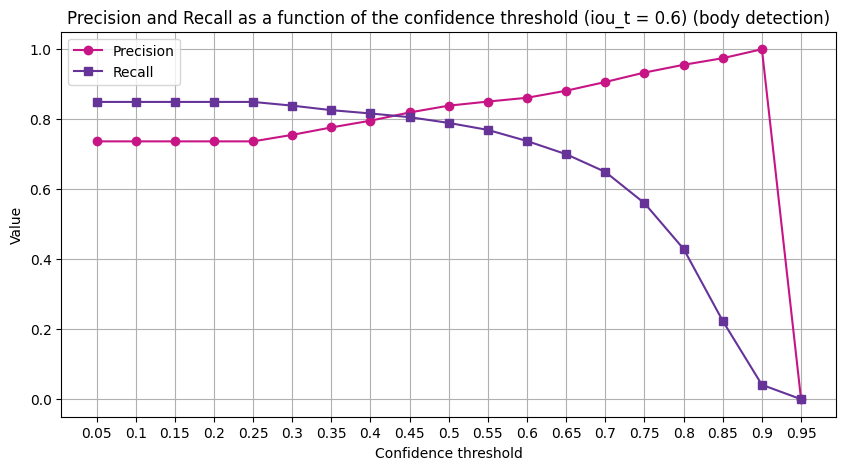

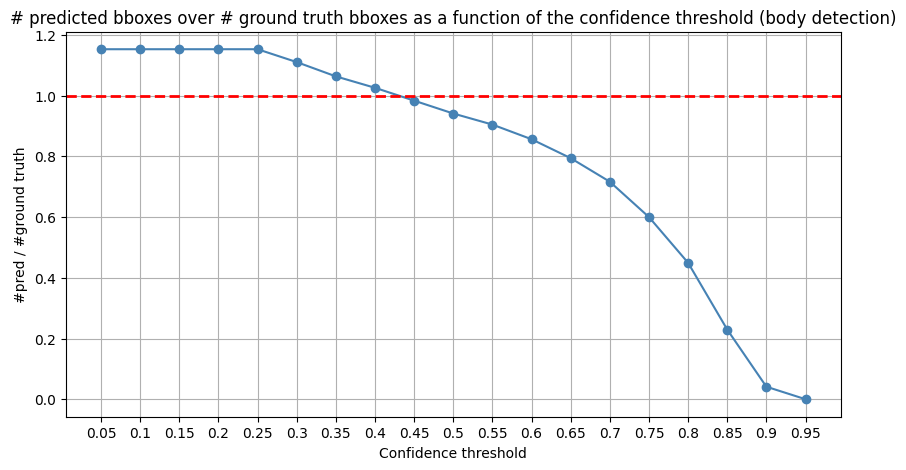

In [17]:
# Sort data by t values
sorted_data = sorted(data.items())  
t_values, pr_recall = zip(*sorted_data)

# Extract precision and recall
precision_values, recall_values = zip(*pr_recall)

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(t_values, precision_values, label="Precision", color="mediumvioletred", marker='o', linestyle='-')
plt.plot(t_values, recall_values, label="Recall", color="rebeccapurple", marker='s', linestyle='-')

# Labels and title
plt.xlabel("Confidence threshold")
plt.ylabel("Value")
plt.title(f"Precision and Recall as a function of the confidence threshold (iou_t = {t}) (body detection)")
plt.legend()
plt.grid(True)

# Set x-axis ticks to show all t values
plt.xticks(t_values, labels=[str(t) for t in t_values])  # Ensuring each t is explicitly labeled

# Display the plot
plt.savefig("plots/PR_according_to_CT_body.svg", format="svg")
plt.show()

n_gt = 0
for values in GT.values():
    n_gt += len(values)

# Create the plot
plt.figure(figsize=(10, 5))
plt.plot(t_values, [i/n_gt for i in n_pred_list], label="ratio n_pred/n_gt", color="steelblue", marker='o', linestyle='-')
plt.axhline(y=1, color='red', linestyle='--', linewidth=2, label="y = 1")

# Labels and title
plt.xlabel("Confidence threshold")
plt.ylabel("#pred / #ground truth")
plt.title(f"# predicted bboxes over # ground truth bboxes as a function of the confidence threshold (body detection)")
plt.grid(True)

# Set x-axis ticks to show all t values
plt.xticks(t_values, labels=[str(t) for t in t_values])  # Ensuring each t is explicitly labeled

# Display the plot
plt.savefig("plots/n_pred_over_n_gt_body.svg", format="svg")
plt.show()

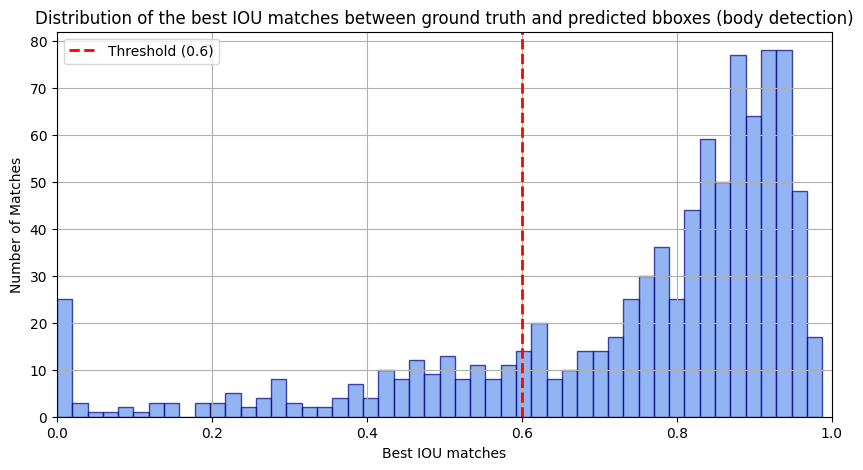

In [18]:
best_matches = []
# Iterate over all unique image names in ground truths and predictions
for image_name in set(GT.keys()).union(predictions.keys()):
    gt_bboxes = GT.get(image_name, [])  # Retrieve ground truth bboxes (default empty list if missing)
    pred_bboxes = predictions.get(image_name, [])  # Retrieve predicted bboxes (default empty list if missing)
    
    # Iterate over each predicted bounding box
    for pred in pred_bboxes:
        best_iou = 0  # Initialize the best IoU score for the current prediction
        
        # Compare prediction with each ground truth bbox
        for gt in gt_bboxes:
            score = iou(pred, gt)  # Compute IoU
            if score > best_iou:  # Update best match if IoU is higher
                best_iou = score

        best_matches.append(best_iou)

# Plot histogram instead of KDE
plt.figure(figsize=(10, 5))
plt.hist(best_matches, bins=50, color="cornflowerblue", edgecolor="navy", alpha=0.7)

plt.axvline(x=t, color='red', linestyle='--', linewidth=2, label=f"Threshold ({t})")

# Labels and title
plt.xlabel("Best IOU matches")
plt.ylabel("Number of Matches")
plt.title("Distribution of the best IOU matches between ground truth and predicted bboxes (body detection)")
plt.xlim(0, 1)  # Ensuring the range stays between 0 and 1
plt.grid(True)

# Add legend
plt.legend(loc="upper left")

# Save and show the plot
plt.savefig("plots/best_matches_distribution_body.svg", format="svg")
plt.show()


In [14]:
# draw_predictions(predictions, GT, test_set, "visualisation")